In [1]:
import sys
sys.path.append('../')
from model.VQAE import VQAE
from model.MARL import MARL
from utils import device, add_noise
from tqdm import tqdm
import torch
from data.FloorPlanLoader import *
import torch.nn.functional as F
import random
import json
import torchvision
import matplotlib.pyplot as plt


USE_MULTISCALE = True
USE_MULTITASK = True

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
epochs = 100
noise=False
noise_weight=0.05
img_channel=3 if USE_MULTISCALE else 1

In [2]:
def train_marl(train_loader=None, validation_loader=None, 
               data_variance=None, val_len=None, year_label_num=None, category_num=None,
               get_pretrain=True, use_multi_task=USE_MULTITASK):
    
    vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
    if get_pretrain:
        vqae.load_state_dict(torch.load("./best_checkpoint/final/55-vqae-0.04753296934928414.pt"))

    marl = MARL(vqae, USE_MULTITASK, year_label_num, category_num)
    optimizer = torch.optim.Adam(marl.parameters(), lr=lr, amsgrad=False)
    train_recon_error = train_height_error = train_age_error = train_usage_error = []
    test_recon_error = test_height_error = test_age_error = test_usage_error = []


    best_loss = 2
    for epoch in range(0, epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            marl.train()
            for data_dict in tepoch:
                data = data_dict['image_tensor']
                bs = data.shape[0]
                data_no_noise = data.to(device)
                optimizer.zero_grad()

                if noise:
                    data = add_noise(data_no_noise, noise_weight=noise_weight)
                else:
                    data = data_no_noise
                pred = marl(data)

                # recon loss
                vq_loss, data_recon, perplexity = pred['vqae']
                recon_error = F.mse_loss(data_recon, data) / data_variance
                train_recon_error.append(recon_error.item())

                if USE_MULTITASK:
                    # height infer
                    height_pred = pred['height']
                    height_error = F.mse_loss(height_pred, data_dict['height'].to(device).view(bs,-1))
                    train_height_error.append(height_error.item())
                    # age infer
                    age_pred = pred['age']
                    labels = data_dict['age_label'].to(device).long()
                    age_error = F.cross_entropy(age_pred, labels)*0.3
                    train_age_error.append(age_error.item())
                    # category infer
                    category_pred = pred['category']
                    labels = data_dict['cate_onehot'].to(device)
                    criterion = torch.nn.BCEWithLogitsLoss()
                    category_error = criterion(category_pred, labels)*0.7
                    train_usage_error.append(category_error.item())

                loss = (recon_error + vq_loss) + height_error + age_error + category_error
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(recon_error=float((recon_error+ vq_loss).detach().cpu()),
                                   height_error=float(height_error.detach().cpu()),
                                   age_error=float(age_error.detach().cpu()),
                                   category_error=float(category_error.detach().cpu()))
                
        avg_loss = 0
        marl.eval()
        with torch.no_grad():
            for data_dict in validation_loader:
                data = data_dict['image_tensor']
                bs = data.shape[0]
                data = data.to(device)

                pred = marl(data)
                # recon loss
                vq_loss, data_recon, perplexity = pred['vqae']
                recon_error = F.mse_loss(data_recon, data) / data_variance
                test_recon_error.append(recon_error.item())

                if USE_MULTITASK:
                    # height infer
                    height_pred = pred['height']
                    height_error = F.mse_loss(height_pred, data_dict['height'].to(device).view(bs,-1))
                    test_height_error.append(height_error.item())
                    # age infer
                    age_pred = pred['age']
                    labels = data_dict['age_label'].to(device).long()
                    age_error = F.cross_entropy(age_pred, labels)*0.3
                    test_age_error.append(age_error.item())
                    # category infer
                    category_pred = pred['category']
                    labels = data_dict['cate_onehot'].to(device)
                    criterion = torch.nn.BCEWithLogitsLoss()
                    category_error = criterion(category_pred, labels)*0.7
                    test_usage_error.append(category_error.item())

                loss = (recon_error.item() \
                        + height_error.item()\
                        + age_error.item()\
                        + category_error.item()\
                        ) * batch_size
                avg_loss += loss / val_len
                
                
        if epoch%5==0 and avg_loss<best_loss:
            best_loss = avg_loss
            best_epoch = epoch
            torch.save(marl.state_dict(), f"./checkpoint/{best_epoch}-vqae-{best_loss}.pt")
            torch.save(optimizer.state_dict(), f"./checkpoint/{best_epoch}-adam-{best_loss}.pt")
            if USE_MULTITASK:
                error = {
                    'train_recon_error': train_recon_error,
                    'train_height_error': train_height_error,
                    'train_age_error': train_age_error,
                    'train_usage_error': train_usage_error,
                    'test_recon_error': test_recon_error,
                    'test_height_error': test_height_error,
                    'test_age_error': test_age_error,
                    'test_usage_error': test_usage_error
                }
            else:
                error = {
                    'train_recon_error': train_recon_error,
                    'test_recon_error': test_recon_error
                }
            with open(f"./checkpoint/{best_epoch}-error-{best_loss}.json", 'w', encoding ='utf8') as json_file:
                json.dump(error, json_file, ensure_ascii = False)

        print(f'Validation Loss: {avg_loss}')


In [3]:
#Load Dataset
floor = FloorPlanDataset(multi_scale=True, root='../data/data_root/data00/', data_config='../data/data_config/', preprocess=True)
data_variance = floor.var
val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])

print(f"data shape: {floor[0]['image_tensor'].shape}, dataset size: {len(floor)}, data variance: {data_variance}")
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([3, 112, 112]), dataset size: 70597, data variance: 0.020686835050582886


In [4]:
vqae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
            n_embeddings, embedding_dim, 
            beta, img_channel).to(device)
marl = MARL(vqae, True, floor.age_label_num, floor.category_num)
marl.load_state_dict(torch.load("../best_checkpoint/final/10-marl-0.7733164590012002.pt"))

<All keys matched successfully>

In [7]:
import json
with open("../checkpoint/5-error-1.5788981096286294.json") as json_file:
    error = json.load(json_file)

In [9]:
error['train_recon_error']

[0.04957063868641853,
 0.7608709335327148,
 0.166696697473526,
 0.28562095761299133,
 2.763523817062378,
 0.6050995588302612,
 0.6783449053764343,
 0.48003607988357544,
 0.3395533859729767,
 0.40346118807792664,
 0.5136620998382568,
 0.5305700898170471,
 0.48984354734420776,
 0.425886332988739,
 0.44056349992752075,
 0.5320861339569092,
 0.5177028179168701,
 0.5834720730781555,
 0.6647374033927917,
 0.6516101360321045,
 0.5443146228790283,
 0.49946680665016174,
 0.5672491192817688,
 0.495445191860199,
 0.45665496587753296,
 0.43062692880630493,
 0.4446199834346771,
 0.4157826006412506,
 0.36684662103652954,
 0.3953497111797333,
 0.38027939200401306,
 0.3681304454803467,
 0.35693806409835815,
 0.32730913162231445,
 0.3094739317893982,
 0.31025055050849915,
 0.3107072114944458,
 0.30362024903297424,
 0.2727722227573395,
 0.2777572274208069,
 0.2748633027076721,
 0.2641940712928772,
 0.26994726061820984,
 0.26018935441970825,
 0.24969519674777985,
 0.26202309131622314,
 0.2496026605367660

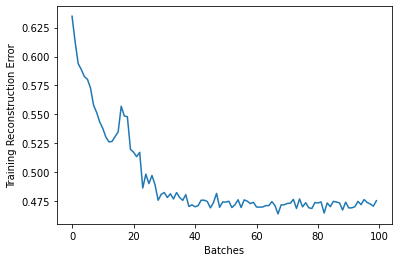

In [19]:
plt.plot(error['train_usage_error'][:100])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()


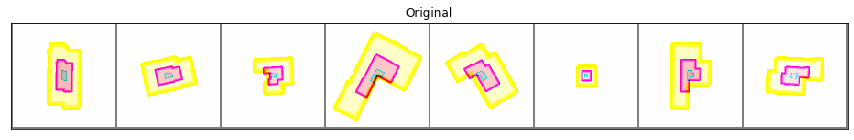

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


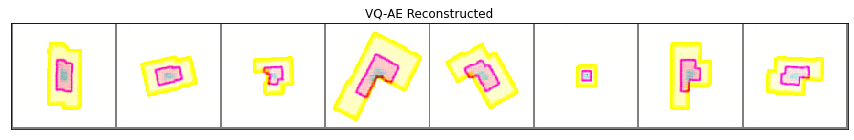

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


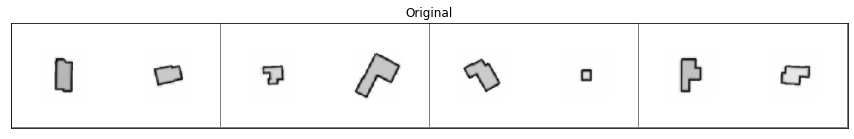

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


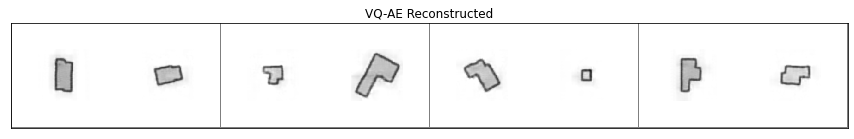

In [22]:

vqae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=8,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals['image_tensor'].to(device)

_, valid_recon, _ = vqae(valid_originals)

def show(img, title):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)

plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_originals.cpu()) + 0.5, "Original")
plt.show()
plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-AE Reconstructed")
plt.show()

def rescale_img(multi_scaled_channels): #B,C,H,W
    composed_1 = transforms.Resize(700)
    composed_2 = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.Pad(238, fill=1.0)])
    composed_3 = transforms.Pad(294, fill=1.0)
    composed_0 = transforms.Compose([transforms.Grayscale(),
                        transforms.CenterCrop(224)])
    
    channel_1 = composed_1(multi_scaled_channels[:,0:1,:,:])
    channel_2 = composed_2(multi_scaled_channels[:,1:2,:,:])
    channel_3 = composed_3(multi_scaled_channels[:,2:3,:,:])
    return composed_0(torch.cat([channel_1,channel_2,channel_3], dim=1))

valid_originals = rescale_img(valid_originals)
valid_recon = rescale_img(valid_recon)

plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
plt.figure(figsize=(15,10))
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-AE Reconstructed")
plt.show()

In [21]:
marl.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals['image_tensor'].to(device)

valid_recon = marl(valid_originals)
valid_recon

{'latent': tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],
 
          [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.00